# Speech Emotion Recognition

The objective of this notebook is to classify from raw sound waves to six emotions: happy, sad, neutral, fear, angry, and disgust. 

1. Gathering data
2. Quick EDA
3. Preprocess
4. Extract features
5. Build a LSTM
6. Evaluate and conclude

Datasets:
* Crowd-sourced Emotional Multimodal Actors Dataset (Crema-D)
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* Surrey Audio-Visual Expressed Emotion (Savee)
* Toronto Emotional Speech Set (Tessa)

# 1. Gathering data

We will gather speech data from four datasets and store it in a single dataframe along with the corresponding file paths, gender labels and emotion labels. The size of each respective dataframe will be specified, along with an example filename in which the emotion label is bolded. 

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
RAVDESS = "data/Audio_Speech_Actors_01-24/"
CREMA = "data/CREMAD/"
TESS = "data/TESS/"
SAVEE = "data/SAVEE/"

**1. Ravdess Dataframe**

There are 1440 audio files, for example, 03-01-**06**-01-02-01-12.wav.

In [3]:
ravdess_dir_lis = os.listdir(RAVDESS)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    '03' : 'happy',
    '01' : 'neutral',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fear',
    '07' : 'disgust',
}

for directory in ravdess_dir_lis:
    actor_files = os.listdir(os.path.join(RAVDESS, directory))
    for audio_file in actor_files: 
        part = audio_file.split('.')[0]
        key = part.split('-')[2]
        if key in emotion_dic:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{RAVDESS}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(emotion_dic[key])
            
ravdess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

ravdess_df.tail()

,path,sex,emotion
1051,data/Audio_Speech_Actors_01-24/Actor_11/03-01-...,male,sad
1052,data/Audio_Speech_Actors_01-24/Actor_11/03-01-...,male,angry
1053,data/Audio_Speech_Actors_01-24/Actor_11/03-01-...,male,disgust
1054,data/Audio_Speech_Actors_01-24/Actor_11/03-01-...,male,sad
1055,data/Audio_Speech_Actors_01-24/Actor_11/03-01-...,male,fear


**2. Crema-D Dataframe**

There are 7,442 audio files, for example, 1001_DFA_**ANG**_XX.wav.

In [4]:
crema_dir_list = os.listdir(CREMA)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

female_id_list = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018', 
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047', 
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072', 
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
]

for audio_file in crema_dir_list:
    part = audio_file.split('_')
    key = part[2]
    if key in emotion_dic and part[3] == 'HI.wav':
        path_list.append(f"{CREMA}{audio_file}")
        gender_list.append('female' if part[0] in female_id_list else 'male')
        emotion_list.append(emotion_dic[key])

crema_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

crema_df.head()

,path,sex,emotion
0,data/CREMAD/1056_IEO_FEA_HI.wav,female,fear
1,data/CREMAD/1074_IEO_HAP_HI.wav,female,happy
2,data/CREMAD/1071_IEO_ANG_HI.wav,male,angry
3,data/CREMAD/1089_IEO_DIS_HI.wav,female,disgust
4,data/CREMAD/1036_IEO_HAP_HI.wav,male,happy


**3. Tess Dataframe**

There are 2,800 audio files, for example, OAF_base_**fear**.wav.

In [5]:
tess_dir_list = os.listdir(TESS)
path_list = []
gender_list = []
emotion_list = [] 

emotion_dic = {
    'happy'   : 'happy',
    'neutral' : 'neutral',
    'sad'     : 'sad',
    'angry'   : 'angry',
    'fear'    : 'fear',
    'disgust'  : 'disgust',
}

for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(TESS, directory))
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        try:key = part.split('_')[2]
        except Exception: print(part)
        if key in emotion_dic:
            path_list.append(f"{TESS}{directory}/{audio_file}") 
            gender_list.append('female') # female only dataset
            emotion_list.append(emotion_dic[key])
            
tess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

tess_df.head()

,path,sex,emotion
0,data/TESS/YAF_sad/YAF_neat_sad.wav,female,sad
1,data/TESS/YAF_sad/YAF_keep_sad.wav,female,sad
2,data/TESS/YAF_sad/YAF_sub_sad.wav,female,sad
3,data/TESS/YAF_sad/YAF_chair_sad.wav,female,sad
4,data/TESS/YAF_sad/YAF_name_sad.wav,female,sad


**4. Savee Dataframe**

There are 480 audio files, for example, DC_**a**02.wav.

In [6]:
savee_dir_list = os.listdir(SAVEE)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'h'  : 'happy',
    'n'  : 'neutral',
    'sa' : 'sad',
    'a'  : 'angry',
    'f'  : 'fear',
    'd'  : 'disgust'
}

for audio_file in savee_dir_list:
    part = audio_file.split('_')[1]
    key = part[:-6]
    if key in emotion_dic:
        path_list.append(f"{SAVEE}{audio_file}")
        gender_list.append('male') # male only dataset
        emotion_list.append(emotion_dic[key])
        
savee_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

savee_df.tail()

,path,sex,emotion
415,data/SAVEE/DC_d02.wav,male,disgust
416,data/SAVEE/JK_n09.wav,male,neutral
417,data/SAVEE/KL_a14.wav,male,angry
418,data/SAVEE/DC_f04.wav,male,fear
419,data/SAVEE/JK_a07.wav,male,angry


In [7]:
import os
import pandas as pd
import numpy as np

datapath = "finetune_data2/"
dirs = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']

path_list = []
emotion_list = []

for dir in dirs:
    mood_files = os.listdir(os.path.join(datapath, dir))
    for audio_file in mood_files:
        path_list.append(f"{datapath}{dir}/{audio_file}")
        emotion_list.append(dir)

finetune_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

finetune_df.tail()

,path,emotion
58,finetune_data2/disgust/2284c8260bbb790c0558fd4...,disgust
59,finetune_data2/disgust/d921772e498a7eba47d48a1...,disgust
60,finetune_data2/disgust/869dbc3cf2ce7103d1ddc16...,disgust
61,finetune_data2/disgust/4ff6494627f446502665d93...,disgust
62,finetune_data2/disgust/1462083f94ab487e0ef40bc...,disgust


In [8]:
df = pd.concat([
    ravdess_df,
    crema_df,
    tess_df,
    savee_df,
    finetune_df,
], axis=0, ignore_index=True)
df.tail()

,path,sex,emotion
4389,finetune_data2/disgust/2284c8260bbb790c0558fd4...,NaN,disgust
4390,finetune_data2/disgust/d921772e498a7eba47d48a1...,NaN,disgust
4391,finetune_data2/disgust/869dbc3cf2ce7103d1ddc16...,NaN,disgust
4392,finetune_data2/disgust/4ff6494627f446502665d93...,NaN,disgust
4393,finetune_data2/disgust/1462083f94ab487e0ef40bc...,NaN,disgust


# 2. Quick EDA

We check for imbalances like male to female ratio. 

In [9]:
import librosa
import matplotlib.pyplot as plt

plt.style.use('ggplot')

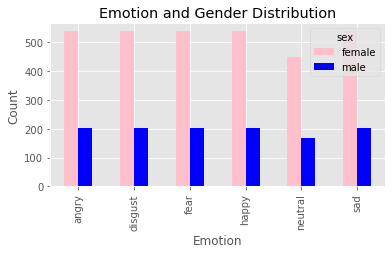

In [10]:
def plot_distribution(df): 
    countTable = df.groupby(['emotion', 'sex']).count()
    pivotTable = countTable.pivot_table(index='emotion', columns='sex', values='path')

    pivotTable.plot(kind='bar', figsize=(6, 3), color=['pink', 'blue'])
    plt.title('Emotion and Gender Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()
    
plot_distribution(df)

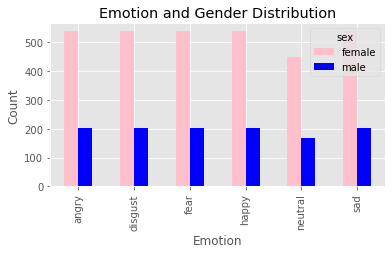

In [11]:
# df = df[df['sex'] == 'female']
plot_distribution(df)

In [12]:
df.drop('sex', axis=1, inplace=True)
df.tail()

,path,emotion
4389,finetune_data2/disgust/2284c8260bbb790c0558fd4...,disgust
4390,finetune_data2/disgust/d921772e498a7eba47d48a1...,disgust
4391,finetune_data2/disgust/869dbc3cf2ce7103d1ddc16...,disgust
4392,finetune_data2/disgust/4ff6494627f446502665d93...,disgust
4393,finetune_data2/disgust/1462083f94ab487e0ef40bc...,disgust


In [13]:
from IPython.display import Audio

def create_waveplot(y, sr, title):
    plt.figure(figsize=(8, 2))
    plt.title(title)
    librosa.display.waveshow(y, sr=sr)
    plt.show()

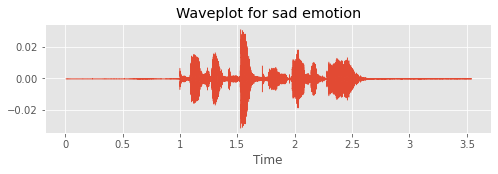

In [14]:
emotion_label = 'sad'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(df.path[df.emotion == emotion_label])[1]
y, sr = librosa.load(path)

create_waveplot(y, sr, title)
Audio(path)

# 3. Preprocess

The following steps will be followed to preprocess the audio: 

1. Get an array of samples
2. Trim the silence  
3. Padding for equal length

In [15]:
from pydub import AudioSegment, effects

In [16]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    # print(sr)
    padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

In [17]:
emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2, 
    'angry'   : 3, 
    'fear'    : 4, 
    'disgust' : 5
}

def encode(label):
    return emotion_dic.get(label)

# 4. Extract features

We will only extract these features: 

1. Mel-Frequency Cepstral Coefficients: captures the shape of the spectral envelope of a signal
2. Zero Crossing Rate: captures the number of times a signal changes sign per second
3. Root Mean Square Energy: captures the root mean square amplitude of the audio signal

In [18]:
zcr_list = []
rms_list = []
mfccs_list = []
tonnetz_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in df.itertuples(index=False):
    try: 
        y, sr = preprocess_audio(row.path)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)
        tonnetz_list.append(tonnetz)

        emotion_list.append(encode(row.emotion))
        # print("success")
    except:
        print(f"Failed for path: {row.path}")

Failed for path: data/SAVEE/JK_sa04.wav
Failed for path: data/SAVEE/DC_d09.wav
Failed for path: data/SAVEE/JK_d14.wav
Failed for path: data/SAVEE/JE_n15.wav
Failed for path: data/SAVEE/JE_d09.wav
Failed for path: data/SAVEE/DC_sa12.wav
Failed for path: data/SAVEE/DC_h05.wav
Failed for path: data/SAVEE/DC_h11.wav
Failed for path: data/SAVEE/JK_f07.wav
Failed for path: data/SAVEE/JE_sa10.wav
Failed for path: data/SAVEE/DC_sa04.wav
Failed for path: data/SAVEE/JK_sa05.wav
Failed for path: data/SAVEE/JE_d01.wav
Failed for path: data/SAVEE/JE_d15.wav
Failed for path: data/SAVEE/JK_a01.wav
Failed for path: data/SAVEE/JK_n01.wav
Failed for path: data/SAVEE/KL_sa15.wav
Failed for path: data/SAVEE/DC_f11.wav
Failed for path: data/SAVEE/JK_n11.wav
Failed for path: data/SAVEE/JE_sa05.wav
Failed for path: data/SAVEE/KL_sa05.wav
Failed for path: data/SAVEE/DC_d08.wav
Failed for path: data/SAVEE/JK_f15.wav
Failed for path: data/SAVEE/JK_n30.wav
Failed for path: data/SAVEE/DC_d15.wav
Failed for path: 

In [19]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2), 
    np.swapaxes(rms_list, 1, 2), 
    np.swapaxes(mfccs_list, 1, 2), 
    np.swapaxes(tonnetz_list, 1, 2)), 
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)
print(X.shape)
y = np.expand_dims(y, axis=1).astype('int8')

(4231, 352, 21)


# 5. Build a LSTM

Before building the model, we will have to setup the data. LSTM are great for sequences.  

In [20]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

2024-07-03 23:57:43.604888: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 23:57:43.796094: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 23:57:44.981317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [21]:
X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.5, random_state=1)

y_train_class = to_categorical(y_train, 6)
y_val_class = to_categorical(y_val, 6)
y_test_class = to_categorical(y_test, 6)

print(len(X_train), len(X_val), len(X_test))

3384 423 424


In [22]:
from keras.models import Sequential
from keras import layers, optimizers, callbacks

In [23]:
import tensorflow as tf; print(len(tf.config.list_physical_devices('GPU')))

1


2024-07-03 23:57:46.309510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 23:57:46.591962: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 23:57:46.592027: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [24]:
MODEL = Sequential()
MODEL.add(layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1:3])))
MODEL.add(layers.LSTM(64))
MODEL.add(layers.Dense(6, activation='softmax'))

print(MODEL.summary())

2024-07-03 23:57:46.608471: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 23:57:46.608578: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 23:57:46.608602: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 23:57:46.807564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 23:57:46.807642: I external/local_xla/xla/stream_executor

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 352, 64)        │        22,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,430 (216.52 KB)

 Trainable params: 55,430 (216.52 KB)

 Non-trainable params: 0 (0.00 B)

None


In [25]:
import keras

# MODEL = keras.saving.load_model("model2.keras")

rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.01, patience=100)
MODEL.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['categorical_accuracy'])
model = MODEL.fit(X_train, y_train_class, epochs=200, batch_size=10, validation_data=(X_val, y_val_class))


Epoch 1/200


2024-07-03 23:57:50.897782: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
2024-07-03 23:57:51.104572: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:190] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-07-03 23:57:51.229318: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:190] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-07-03 23:57:51.280307: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:190] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


  6/339 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - categorical_accuracy: 0.2008 - loss: 1.8369

2024-07-03 23:57:51.370955: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:190] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


339/339 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - categorical_accuracy: 0.2401 - loss: 1.7077 - val_categorical_accuracy: 0.4090 - val_loss: 1.4399
Epoch 2/200
339/339 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - categorical_accuracy: 0.4127 - loss: 1.4387 - val_categorical_accuracy: 0.4326 - val_loss: 1.3698
Epoch 3/200
339/339 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - categorical_accuracy: 0.4296 - loss: 1.3741 - val_categorical_accuracy: 0.4681 - val_loss: 1.3364
Epoch 4/200
339/339 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - categorical_accuracy: 0.4683 - loss: 1.3379 - val_categorical_accuracy: 0.3593 - val_loss: 1.5179
Epoch 5/200
339/339 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - categorical_accuracy: 0.5001 - loss: 1.2827 - val_categorical_accuracy: 0.4444 - val_loss: 1.2854
Epoch 6/200
339/339 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - categorical_accuracy: 0.5062 - loss: 1.2321 - val_categorical_accuracy: 0.4870 - val_loss: 1.2872
Epoch 7/200
339/339 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - categorical_accuracy: 0.5256 - 

# 6. Evaluate and conclude

Let's see how good are model is. 

In [26]:
from sklearn.metrics import confusion_matrix

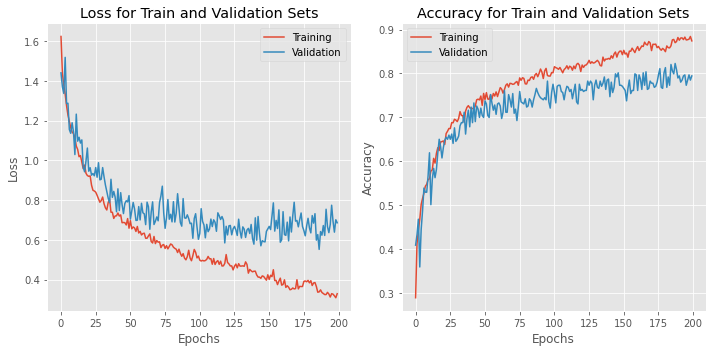

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(model.history['loss'])
axes[0].plot(model.history['val_loss'])
axes[0].set_title('Loss for Train and Validation Sets')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training', 'Validation'])

axes[1].plot(model.history['categorical_accuracy'])
axes[1].plot(model.history['val_categorical_accuracy'])
axes[1].set_title('Accuracy for Train and Validation Sets')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training', 'Validation'])

fig.tight_layout()

plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0.8113207547169812


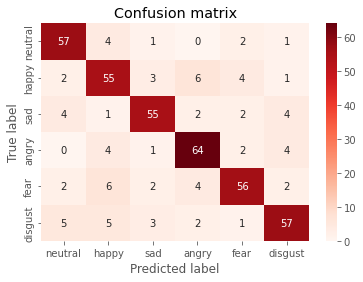

In [28]:
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score

y_pred = np.argmax(MODEL.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred) ; print(accuracy)
labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']
cm = confusion_matrix(np.argmax(y_test_class, axis=1), y_pred, labels=range(6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

**Conclusion**

In summary, our model achieved 90% accuracy in classifying six different emotions. However, there are several ways we could improve it. For example, we could change the model, obtain a better dataset and extract different features. One optimization that we could make is to generate a codebook and apply vector quantization to reduce the dimensionality. This can help to improve the model's training speed and reduce the risk of overfitting. Lastly, don't forget to use accelerators to speed up the training process. 

In [30]:
MODEL.save('model_v2.keras')